In [1]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [2]:
# query =\
# '''
# -- query for clustering v2
# WITH users AS (
#   SELECT DISTINCT user_id
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
#   WHERE last_transaction_date >= '2023-04-01'
# )

# , loyalty AS (
#   SELECT 
#     user_id, 
#     date_,
#     kyc_tier,
#     loyalty_tier,
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE 
#     date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#     AND kyc_tier <> 'NON_KYC'
# )

# , campaigns AS (
#   SELECT
#     user_id,
#     DATE_ADD(DATE_TRUNC(date_, MONTH), INTERVAL 1 MONTH) AS date_,
#     SUM(daily_OTHER_saldo) AS M1_campaign_saldo
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE date_ BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )


# , payments AS (
#   SELECT
#     user_id,
#     DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
#     -- TRANSACTIONS
#     COUNT(DISTINCT IF(product_type IN ('Payment In', 'Payment Out'), transaction_id, NULL)) AS M1_core_count,
#     COUNT(DISTINCT IF(product_type IN ('PPOB'), transaction_id, NULL)) AS M1_ppob_count,
#     -- CUSTOMER
#     COUNT(DISTINCT IF(product_type = 'PPOB', beneficiaryid_ppob, NULL)) + COUNT(DISTINCT IF(product_type = 'Payment Out', destination_bank_account_number, NULL)) AS total_customer,
#   FROM `ledger-fcc1e.payment_reports.payments_ssot`
#   WHERE
#     status_v2 = 'COMPLETED'
#     AND transaction_date BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )

# , accountings AS (
#   SELECT DISTINCT
#     DATE_ADD(DATE_TRUNC(DATE(trans_createdAt), MONTH), INTERVAL 1 MONTH) AS date_,
#     createdByUser AS user_id,
#     COUNT(DISTINCT transactionId) AS M1_acc_count
#   FROM `ledger-fcc1e.bukuwarung_analytics.accounting_transactions_table_db`
#   WHERE DATE(trans_createdAt) BETWEEN '2023-04-01' AND '2023-07-31'
#   GROUP BY 1, 2
# )

# -- //this is a bit inefficient since i load the same table twice...
# -- //open to idea on how to do it better
# -- , banks AS (
# --   SELECT DISTINCT
# --     user_id,
# --     date_,
# --     ARRAY_AGG(money_in_channel) OVER(PARTITION BY user_id, date_ ORDER BY cnt_ DESC) [OFFSET(0)] AS main_funding_bank
# --   FROM (
# --     SELECT 
# --       user_id,
# --       DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
# --       money_in_channel,
# --       COUNT(*) AS cnt_
# --     FROM `ledger-fcc1e.payment_reports.payments_ssot`
# --     WHERE
# --       status_v2 = 'COMPLETED'
# --       AND product_type IN ('SALDO')
# --       AND transaction_date BETWEEN '2023-04-01' AND '2023-07-01'
# --     GROUP BY 1, 2, 3
# --   )
# -- )

# , referrals AS (
#   SELECT 
#     referrer AS user_id,
#     date_,
#     COUNT(DISTINCT referee) AS referee_count
#   FROM `ledger-fcc1e.trb_mxg_reports.referral_ssot` 
#   WHERE date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#   GROUP BY 1, 2
# )

# , profiles AS (
#   SELECT DISTINCT
#     user_id,
#     acquisition_channel,
#     user_segment_sub_bucket,
#     first_user_date,
#     first_any_payment_date,
#     first_transaction_date
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
# )

# , impressions AS (
#   SELECT
#     SUBSTR(phone_number, 4) AS user_id,
#     DATE_ADD(DATE_TRUNC(notification_date, MONTH), INTERVAL 1 MONTH) AS date_,
#     SUM(pn_count) AS send_count,
#     SUM(impressions_count) AS impressions_count,
#     SUM(read_count) AS read_count,
#     COUNT(DISTINCT user_activated) AS activated_count,
#     COUNT(DISTINCT user_converted) AS converted_count
#   FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
#   WHERE 
#     notification_date BETWEEN '2023-04-01' AND '2023-08-31'
#     AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
#   GROUP BY 1, 2
# )

# SELECT DISTINCT
#   user_id,
#   date_,
#   kyc_tier,
#   loyalty_tier,
#   (CASE WHEN M1_core_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_core_count END) AS M1_core_count,
#   (CASE WHEN M1_ppob_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_ppob_count END) AS M1_ppob_count,
#   (CASE WHEN M1_acc_count IS NULL AND date_ >= first_transaction_date THEN 0 ELSE M1_acc_count END) AS M1_acc_count,
#   M1_campaign_saldo,
#   -- (CASE WHEN M1_core_count > 0 THEN 1 ELSE M1_core_count END) AS M1_core_count,
#   -- (CASE WHEN M1_ppob_count > 0 THEN 1 ELSE M1_ppob_count END) AS M1_ppob_count,
#   -- (CASE WHEN M1_acc_count > 0 THEN 1 ELSE M1_acc_count END) AS M1_acc_count,
#   -- (CASE WHEN M1_campaign_saldo > 0 THEN 1 ELSE M1_campaign_saldo END) AS M1_campaign_saldo,
#   total_customer,
#   -- IFNULL(
#   --   IFNULL(
#   --     LAST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
#   --     FIRST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
#   --   ),
#   --   NULL
#   -- ) AS main_funding_bank,
#   (CASE WHEN referee_count > 0 THEN 1 ELSE 0 END) AS is_referrer,
#   acquisition_channel,
#   user_segment_sub_bucket,
#   DATE_DIFF(date_, first_user_date, DAY) AS age_on_platform_days,
#   CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS is_send_m1,
#   CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS is_imp_m1,
#   CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS is_read_m1,
#   IFNULL(activated_count, 0) AS is_act_m1,
#   IFNULL(converted_count, 0) AS is_conv_m1
# FROM users -- active in last 12 months
# INNER JOIN loyalty USING (user_id) -- needs to be atleast KYC
# LEFT JOIN payments USING (user_id, date_) -- get Q2 transaction data
# -- LEFT JOIN banks USING (user_id, date_)
# LEFT JOIN referrals USING (user_id, date_)
# LEFT JOIN impressions USING (user_id, date_)
# LEFT JOIN accountings USING (user_id, date_)
# LEFT JOIN campaigns USING (user_id, date_)
# LEFT JOIN profiles USING (user_id)
# WHERE date_ < '2023-09-01'
# ORDER BY 1, 2

# '''
# raw = client.query(query).result().to_dataframe()
# raw.to_pickle('data/raw_data_v2.pkl')
raw = pd.read_pickle('data/raw_data_v2.pkl')

# use m1 transaction data
# get profile features which are available to most users
# include more users (who have done kyc and are active in last 12 months)
# check WA impressions and clicks
# in payments_ssot check the bank account when user topup saldo -- main_funding_bank
# can estimate customers as well using payments data
# 


In [3]:
# -- QUERY TO GET IMPRESSIONS COUNT
# imp_query =\
# '''
# WITH users AS (
#   SELECT DISTINCT user_id
#   FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
#   WHERE last_transaction_date >= '2023-04-01'
# )

# , loyalty AS (
#   SELECT user_id, date_
#   FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
#   WHERE 
#     date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
#     AND kyc_tier <> 'NON_KYC'
# )

# , impressions AS (
#   SELECT
#     SUBSTR(phone_number, 4) AS user_id,
#     DATE_TRUNC(notification_date, MONTH) AS date_,
#     SUM(pn_count) AS send_count,
#     SUM(impressions_count) AS impressions_count,
#     SUM(read_count) AS read_count,
#     COUNT(DISTINCT user_activated) AS activated_count,
#     COUNT(DISTINCT user_converted) AS converted_count
#   FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
#   WHERE 
#     notification_date BETWEEN '2023-05-01' AND '2023-08-31'
#     AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
#   GROUP BY 1, 2
# )

# SELECT
#   user_id,
#   date_,
#   CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS send_count,
#   CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS impressions_count,
#   CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS read_count,
#   IFNULL(activated_count, 0) AS activated_count,
#   IFNULL(converted_count, 0) AS conveted_count
# FROM users
# INNER JOIN loyalty USING (user_id)
# LEFT JOIN impressions USING (user_id, date_)
# WHERE send_count IS NOT NULL
# '''
# imp = client.query(imp_query).result().to_dataframe()
# imp.to_pickle('data/raw_imp_v2.pkl')
imp = pd.read_pickle('data/raw_imp_v2.pkl')

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202898 entries, 0 to 202897
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_id                  202898 non-null  object
 1   date_                    202898 non-null  dbdate
 2   kyc_tier                 202898 non-null  object
 3   loyalty_tier             202898 non-null  object
 4   M1_core_count            148403 non-null  Int64 
 5   M1_ppob_count            148403 non-null  Int64 
 6   M1_acc_count             201373 non-null  Int64 
 7   M1_campaign_saldo        202743 non-null  Int64 
 8   total_customer           87924 non-null   Int64 
 9   is_referrer              202898 non-null  Int64 
 10  acquisition_channel      202898 non-null  object
 11  user_segment_sub_bucket  202898 non-null  object
 12  age_on_platform_days     202898 non-null  Int64 
 13  is_send_m1               202898 non-null  Int64 
 14  is_imp_m1           

In [5]:
std_core = np.std(raw['M1_core_count'])
std_ppob = np.std(raw['M1_ppob_count'])
std_acc = np.std(raw['M1_acc_count'])
std_saldo = np.std(raw['M1_campaign_saldo'])
std_age = np.std(raw['age_on_platform_days'])

df =\
(
    raw
    .assign(
        # referee_count = lambda x: x.referee_count.fillna(0),
        date_ = lambda x: x.date_.astype(str),
        index_ = lambda x: x.user_id + " " + x.date_,

        # M1_core_count = lambda x: x.M1_core_count/std_core,
        # M1_acc_count = lambda x: x.M1_acc_count/std_acc,
        # M1_ppob_count = lambda x: x.M1_ppob_count/std_ppob,
        # M1_campaign_saldo = lambda x: x.M1_campaign_saldo/std_saldo,
        # age_on_platform_days = lambda x: x.age_on_platform_days/std_age,
        M1_core_count = lambda x: np.log1p(x.M1_core_count),
        M1_ppob_count = lambda x: np.log1p(x.M1_ppob_count),
        M1_acc_count = lambda x: np.log1p(x.M1_acc_count),
        M1_campaign_saldo = lambda x: np.log1p(x.M1_campaign_saldo),
        age_on_platform_days = lambda x: np.log1p(x.age_on_platform_days),

        is_send_m1 = lambda x: x.is_send_m1.fillna(0),
        is_imp_m1 = lambda x: x.is_imp_m1.fillna(0),
        is_read_m1 = lambda x: x.is_read_m1.fillna(0),
        is_act_m1 = lambda x: x.is_act_m1.fillna(0),
        is_conv_m1 = lambda x: x.is_conv_m1.fillna(0),
    )
    .drop(columns=['user_id', 'date_', 'is_send_m1', 'is_imp_m1', 'is_read_m1', 'is_act_m1', 'is_conv_m1'])
    # .drop(columns=['user_id', 'date_', 'M1_core_count', 'M1_acc_count', 'M1_ppob_count'])
    # .drop(columns=['user_id', 'date_'])
    .set_index('index_')
)
df

,kyc_tier,loyalty_tier,M1_core_count,M1_ppob_count,M1_acc_count,M1_campaign_saldo,total_customer,is_referrer,acquisition_channel,user_segment_sub_bucket,age_on_platform_days
index_,,,,,,,,,,,
1161895687 2023-06-01,ADVANCED,Bronze,0.0,0.693147,1.791759,0.0,1,0,Organic Acquisition,pureO2O-PA+PP,5.736572
1161895687 2023-07-01,ADVANCED,Bronze,0.0,1.098612,0.0,0.0,2,0,Organic Acquisition,pureO2O-PA+PP,5.828946
1161895687 2023-08-01,ADVANCED,Bronze,0.0,3.135494,3.526361,0.0,16,0,Organic Acquisition,pureO2O-PA+PP,5.916202
8111010474 2023-05-01,ADVANCED,Bronze,0.0,0.0,0.693147,0.0,<NA>,0,Paid Acquisition,UNKNOWN,5.988961
8111010474 2023-06-01,ADVANCED,Bronze,0.0,0.0,0.0,0.0,<NA>,0,Paid Acquisition,UNKNOWN,6.063785
...,...,...,...,...,...,...,...,...,...,...,...
8999999365 2023-08-01,SUPREME,Gold,0.0,5.365976,0.0,0.0,158,0,Offline Acquisition,pureO2O-PAonly,6.426488
8999999557 2023-05-01,SUPREME,Diamond,6.747587,1.386294,0.0,8.2943,437,0,Offline Acquisition,pureO2O-PAonly,6.152733
8999999557 2023-06-01,SUPREME,Diamond,6.602588,0.0,0.0,7.601402,318,0,Offline Acquisition,pureO2O-PAonly,6.216606


In [6]:
df.describe()

,M1_core_count,M1_ppob_count,M1_acc_count,M1_campaign_saldo,total_customer,is_referrer,age_on_platform_days
count,148403.0,148403.0,201373.0,202743.0,87924.0,202898.0,202898.0
mean,0.858483,1.215209,1.380325,0.214722,38.775988,0.052613,5.731648
std,1.558708,1.702547,2.013876,1.298263,88.935877,0.223259,1.21572
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,2.0,0.0,4.990433
50%,0.0,0.0,0.0,0.0,11.0,0.0,6.244167
75%,1.098612,2.397895,2.833213,0.0,38.0,0.0,6.60665
max,8.2247,8.548886,9.481817,12.551437,2907.0,1.0,7.26473


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202898 entries, 1161895687 2023-06-01 to 8999999557 2023-08-01
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   kyc_tier                 202898 non-null  object 
 1   loyalty_tier             202898 non-null  object 
 2   M1_core_count            148403 non-null  Float64
 3   M1_ppob_count            148403 non-null  Float64
 4   M1_acc_count             201373 non-null  Float64
 5   M1_campaign_saldo        202743 non-null  Float64
 6   total_customer           87924 non-null   Int64  
 7   is_referrer              202898 non-null  Int64  
 8   acquisition_channel      202898 non-null  object 
 9   user_segment_sub_bucket  202898 non-null  object 
 10  age_on_platform_days     202898 non-null  Float64
dtypes: Float64(5), Int64(2), object(4)
memory usage: 19.9+ MB


In [8]:
s = setup(
    df, 
    normalize=True, 
    ignore_features=['user_id'],
    use_gpu = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(202898, 11)"
2,Transformed data shape,"(202898, 28)"
3,Ignore features,1
4,Ordinal features,1
5,Numeric features,7
6,Categorical features,4
7,Rows with missing values,56.7%
8,Preprocess,True
9,Imputation type,simple


In [9]:
kmeans = create_model('kmeans', num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1515,21853.5726,2.1794,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
# plot_model(kmeans, 'tsne')

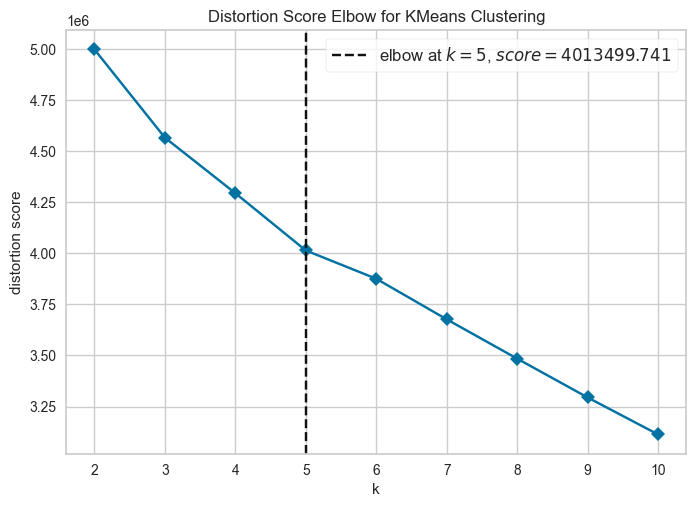

In [11]:
plot_model(kmeans, plot = 'elbow')

In [12]:
# plot_model(kmeans, plot = 'distribution')

In [13]:
imp_df =\
(
    imp
    .assign(
        date_ = lambda x: x.date_.astype(str)
    )
)

In [14]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84116 entries, 0 to 84115
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            84116 non-null  object
 1   date_              84116 non-null  object
 2   send_count         84116 non-null  Int64 
 3   impressions_count  84116 non-null  Int64 
 4   read_count         84116 non-null  Int64 
 5   activated_count    84116 non-null  Int64 
 6   conveted_count     84116 non-null  Int64 
dtypes: Int64(5), object(2)
memory usage: 4.9+ MB


In [15]:
imp_df.describe()

,send_count,impressions_count,read_count,activated_count,conveted_count
count,84116.0,84116.0,84116.0,84116.0,84116.0
mean,1.0,0.889878,0.679585,0.411384,0.221313
std,0.0,0.313043,0.466639,0.492088,0.415134
min,1.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,0.0
max,1.0,1.0,1.0,1.0,1.0


In [16]:
res =\
(
    assign_model(kmeans)
    .reset_index()
    .assign(
        user_id = lambda x: x.index_.str.split(" ", expand=False).str[0],
        date_ = lambda x: x.index_.str.split(" ", expand=False).str[1]
    )
    .drop(columns=['index_'])
    .merge(imp_df, how='right', on=['user_id', 'date_'])
    # .assign(
    #     impressions_count = lambda x: x.impressions_count.fillna(0),
    #     read_count = lambda x: x.read_count.fillna(0),
    # )
)

In [17]:
res.describe()

,M1_core_count,M1_ppob_count,M1_acc_count,M1_campaign_saldo,total_customer,is_referrer,age_on_platform_days,send_count,impressions_count,read_count,activated_count,conveted_count
count,77672.0,77672.0,83595.0,84009.0,62494.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0,84116.0
mean,1.209924,1.836274,0.872669,0.451589,44.31507,0.064138,5.336305,1.0,0.889878,0.679585,0.411384,0.221313
std,1.76174,1.841651,1.72637,1.857508,95.818135,0.244999,1.369059,0.0,0.313043,0.466639,0.492088,0.415134
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,3.0,0.0,4.382027,1.0,1.0,0.0,0.0,0.0
50%,0.0,1.386294,0.0,0.0,13.0,0.0,5.863631,1.0,1.0,1.0,0.0,0.0
75%,2.302585,3.401197,0.693147,0.0,45.0,0.0,6.461468,1.0,1.0,1.0,1.0,0.0
max,8.2247,8.548886,9.481817,12.551437,2907.0,1.0,7.257708,1.0,1.0,1.0,1.0,1.0


In [18]:
res.groupby([ 'date_', 'Cluster']).agg('mean')

M1_core_count  M1_ppob_count  M1_acc_count  \
date_      Cluster                                                 
2023-05-01 Cluster 0       3.408688       2.935785       0.32881   
           Cluster 1       0.079199       1.734142      1.449864   
           Cluster 2       0.893923       1.085733      0.311158   
           Cluster 3        0.03954       1.863122      1.531133   
2023-06-01 Cluster 0       3.206235       2.984878      0.350332   
           Cluster 1        0.11053       1.921917      1.752975   
           Cluster 2       0.716366       0.906951      0.323025   
           Cluster 3       0.040421       2.178654       2.34417   
2023-07-01 Cluster 0       3.238467       2.875532      0.372168   
           Cluster 1       0.190705       1.866918       1.40615   
           Cluster 2       0.556975       0.710023      0.315064   
           Cluster 3       0.064328       2.144621      1.767993   
2023-08-01 Cluster 0       3.088092       2.861379       0.36809   
           Cluster 1       0.085151       2.239788      1.640113   
           Cluster 2       0.917543       1.483487      0.266649   
           Cluster 3       0.028377       2.313278      1.774144   

                      M1_campaign_saldo  total_customer  is_referrer  \
date_      Cluster                                                     
2023-05-01 Cluster 0            1.48874      137.652817      0.15751   
           Cluster 1           0.290781       11.786192       0.0451   
           Cluster 2           0.108974        11.86136     0.027282   
           Cluster 3           0.210385       12.159367     0.031541   
2023-06-01 Cluster 0           0.486146      108.696111     0.146073   
           Cluster 1           0.004461       12.495775     0.038146   
           Cluster 2           0.065012       10.061878     0.025875   
           Cluster 3           0.003705       12.405992     0.016926   
2023-07-01 Cluster 0           2.414996       99.850727     0.155917   
           Cluster 1           0.049183       12.849706      0.05649   
           Cluster 2           0.168717        9.647324     0.038257   
           Cluster 3           0.025097       12.096909     0.032794   
2023-08-01 Cluster 0           1.159886      106.466768     0.160816   
           Cluster 1           0.013083       15.977462     0.064626   
           Cluster 2           0.129092       12.282431      0.04156   
           Cluster 3           0.001502       13.340047     0.034917   

                      age_on_platform_days  send_count  impressions_count  \
date_      Cluster                                                          
2023-05-01 Cluster 0               5.52747         1.0           0.905424   
           Cluster 1              6.249266         1.0           0.910913   
           Cluster 2              4.753593         1.0           0.891289   
           Cluster 3              5.376445         1.0           0.897436   
2023-06-01 Cluster 0              5.628024         1.0             0.9007   
           Cluster 1              6.300007         1.0           0.914906   
           Cluster 2               4.77932         1.0           0.874896   
           Cluster 3              4.785941         1.0           0.915694   
2023-07-01 Cluster 0              5.926112         1.0           0.894279   
           Cluster 1              6.360764         1.0           0.899126   
           Cluster 2              5.192883         1.0           0.866667   
           Cluster 3              5.275851         1.0           0.895807   
2023-08-01 Cluster 0              5.987356         1.0           0.885415   
           Cluster 1               6.43767         1.0           0.895238   
           Cluster 2              5.049734         1.0           0.869966   
           Cluster 3              5.337455         1.0           0.891116   

                      read_count  activated_count  conveted_count  
date_      Cluster                           

In [19]:
res.groupby([ 'date_', 'Cluster']).agg('count')

kyc_tier  loyalty_tier  M1_core_count  M1_ppob_count  \
date_      Cluster                                                           
2023-05-01 Cluster 0      2876          2876           2876           2876   
           Cluster 1      1796          1796           1778           1778   
           Cluster 2      7221          7221           7134           7134   
           Cluster 3      4407          4407           4219           4219   
2023-06-01 Cluster 0      3998          3998           3998           3998   
           Cluster 1      1704          1704           1319           1319   
           Cluster 2      8425          8425           8342           8342   
           Cluster 3      9335          9335           4119           4119   
2023-07-01 Cluster 0      7132          7132           7132           7132   
           Cluster 1      1487          1487           1473           1473   
           Cluster 2     12390         12390          12340          12340   
           Cluster 3      4818          4818           4611           4611   
2023-08-01 Cluster 0      7549          7549           7549           7549   
           Cluster 1      1470          1470           1449           1449   
           Cluster 2      4668          4668           4650           4650   
           Cluster 3      4840          4840           4683           4683   

                      M1_acc_count  M1_campaign_saldo  total_customer  \
date_      Cluster                                                      
2023-05-01 Cluster 0          2876               2876            2840   
           Cluster 1          1794               1796            1347   
           Cluster 2          7160               7219            5590   
           Cluster 3          4340               4392            3288   
2023-06-01 Cluster 0          3998               3998            3883   
           Cluster 1          1700               1704            1065   
           Cluster 2          8378               8422            5430   
           Cluster 3          9168               9293            3638   
2023-07-01 Cluster 0          7132               7132            7014   
           Cluster 1          1483               1487            1191   
           Cluster 2         12357              12372            6445   
           Cluster 3          4752               4807            4076   
2023-08-01 Cluster 0          7549               7549            7222   
           Cluster 1          1469               1470            1198   
           Cluster 2          4654               4667            4047   
           Cluster 3          4785               4825            4220   

                      is_referrer  acquisition_channel  \
date_      Cluster                                       
2023-05-01 Cluster 0         2876                 2876   
           Cluster 1         1796                 1796   
           Cluster 2         7221                 7221   
           Cluster 3         4407                 4407   
2023-06-01 Cluster 0         3998                 3998   
           Cluster 1         1704                 1704   
           Cluster 2         8425                 8425   
           Cluster 3         9335                 9335   
2023-07-01 Cluster 0         7132                 7132   
           Cluster 1         1487                 1487   
           Cluster 2        12390                12390   
           Cluster 3         4818                 4818   
2023-08-01 Cluster 0         7549                 7549   
           Cluster 1         1470                 1470   
           Cluster 2         4668                 4668   
           Cluster 3         4840                 4840   

                      user_segment_sub_bucket  age_on_platform_days  user_id  \
date_      Cluster                                                             
2023-05-01 Cluster 0                     2876                  2876     2876   
           Cluste